### RAG system baseline compared to one with a reranker

In [72]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import pipeline
import numpy as np
import torch
import time
import matplotlib.pyplot as plt


In [ ]:
# Load a small subset of SQuAD train to build the corpus
squad_train = load_dataset("squad", split="validation")  # first 500 examples

# Deduplicate contexts
seen = set()
docs = []
for ex in squad_train:
    ctx = ex["context"]
    if ctx not in seen:
        seen.add(ctx)
        docs.append(ctx)

print(f"Number of unique documents: {len(docs)}")


In [ ]:
# Bi-encoder for dense retrieval
retriever_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode all docs
doc_embeddings = retriever_model.encode(
    docs,
    convert_to_numpy=True,
    normalize_embeddings=True,
    batch_size=64,
    show_progress_bar=True,
)

doc_embeddings.shape


Batches: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s]


(2067, 384)

In [ ]:
# Cross-encoder reranker
reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Extractive QA model (off-the-shelf, trained on SQuAD)
device = 0 if torch.cuda.is_available() else -1
qa_pipeline = pipeline(
    "question-answering",
    model="deepset/roberta-base-squad2",
    tokenizer="deepset/roberta-base-squad2",
    device=device,
)


Device set to use cpu


In [ ]:
def retrieve_top_k(query: str, k: int = 10):
    """
    Bi-encoder retrieval: returns indices of top-k docs by cosine similarity.
    """
    q_emb = retriever_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    sims = doc_embeddings @ q_emb  # cosine since normalized
    top_k_idx = np.argsort(-sims)[:k]
    return top_k_idx.tolist(), sims[top_k_idx]


def rerank_top_k(query: str, candidate_indices, k: int = 5):
    """
    Cross-encoder reranking over candidate docs.
    """
    pairs = [(query, docs[i]) for i in candidate_indices]
    scores = reranker_model.predict(pairs)
    order = np.argsort(-scores)
    top_idx = [candidate_indices[i] for i in order[:k]]
    return top_idx, scores[order[:k]]


In [ ]:
def answer_baseline(question: str) -> str:
    cand_idx, _ = retrieve_top_k(question, k=5)
    best_doc_idx = cand_idx[0]
    context = docs[best_doc_idx]
    out = qa_pipeline(question=question, context=context)
    return out["answer"]


def answer_rerank(question: str) -> str:
    cand_idx, _ = retrieve_top_k(question, k=20)
    reranked_idx, _ = rerank_top_k(question, cand_idx, k=5)
    best_doc_idx = reranked_idx[0]
    context = docs[best_doc_idx]
    out = qa_pipeline(question=question, context=context)
    return out["answer"]


In [ ]:
squad_val_small = load_dataset("squad", split="validation[:10]")

ex = squad_val_small[0]
q = ex["question"]
gold = ex["answers"]["text"]

print("Question:", q)
print("Gold answers:", gold)

pred_base = answer_baseline(q)
pred_rerank = answer_rerank(q)

print("\nBaseline answer:", pred_base)
print("Reranked answer:", pred_rerank)


Question: Which NFL team represented the AFC at Super Bowl 50?
Gold answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

Baseline answer: Denver Broncos
Reranked answer: Denver Broncos


In [ ]:
def normalize_text(s: str) -> str:
    return s.strip().lower()


def exact_match(pred: str, gold_list) -> int:
    pred_n = normalize_text(pred)
    gold_n = [normalize_text(g) for g in gold_list]
    return int(pred_n in gold_n)


def evaluate_system(answer_fn, dataset, n: int = 50):
    scores = []
    for i in range(n):
        ex = dataset[i]
        q = ex["question"]
        gold = ex["answers"]["text"]

        pred = answer_fn(q)
        scores.append(exact_match(pred, gold))

        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{n} questions...")
    return float(np.mean(scores))


In [ ]:
N_TEST = 300
squad_val = load_dataset("squad", split=f"validation[:{N_TEST}]")

print("Evaluating baseline RAG (retriever only)...")
acc_base = evaluate_system(answer_baseline, squad_val, n=N_TEST)
print(f"\nBaseline EM on {N_TEST} questions: {acc_base:.3f}")

print("\nEvaluating RAG + reranker...")
acc_rerank = evaluate_system(answer_rerank, squad_val, n=N_TEST)
print(f"\nRAG + reranker EM on {N_TEST} questions: {acc_rerank:.3f}")


Evaluating baseline RAG (retriever only)...
Processed 10/50 questions...
Processed 20/50 questions...
Processed 30/50 questions...
Processed 40/50 questions...
Processed 50/50 questions...

Baseline EM on 50 questions: 0.640

Evaluating RAG + reranker...
Processed 10/50 questions...
Processed 20/50 questions...
Processed 30/50 questions...
Processed 40/50 questions...
Processed 50/50 questions...

RAG + reranker EM on 50 questions: 0.720


In [ ]:
def inspect_example(idx: int):
    ex = squad_val[idx]
    q = ex["question"]
    gold = ex["answers"]["text"]

    print(f"Example {idx}")
    print("Question:", q)
    print("Gold answers:", gold)

    base_ans = answer_baseline(q)
    rerank_ans = answer_rerank(q)

    print("\nBaseline answer: ", base_ans)
    print("Reranked answer: ", rerank_ans)

# Example usage:
for i in range(50):
    inspect_example(i)


Example 0
Question: Which NFL team represented the AFC at Super Bowl 50?
Gold answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

Baseline answer:  Denver Broncos
Reranked answer:  Denver Broncos
Example 1
Question: Which NFL team represented the NFC at Super Bowl 50?
Gold answers: ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers']

Baseline answer:  Carolina Panthers
Reranked answer:  Carolina Panthers
Example 2
Question: Where did Super Bowl 50 take place?
Gold answers: ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."]

Baseline answer:  Levi's Stadium in the San Francisco Bay Area at Santa Clara, California
Reranked answer:  Levi's Stadium in the San Francisco Bay Area at Santa Clara, California
Example 3
Question: Which NFL team won Super Bowl 50?
Gold answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

Baseline answer:  Denver Broncos
Reranked answer:  Denver Broncos
Exam

In [ ]:
def answer_baseline_retrievalk(question, k):
    cand_idx, _ = retrieve_top_k(question, k=k)
    best = cand_idx[0]
    context = docs[best]
    return qa_pipeline(question=question, context=context)["answer"]

def answer_rerank_retrievalk(question, k):
    cand_idx, _ = retrieve_top_k(question, k=k)
    reranked, _ = rerank_top_k(question, cand_idx, k=5)
    best = reranked[0]
    context = docs[best]
    return qa_pipeline(question=question, context=context)["answer"]


In [ ]:

retrieval_ks = [5, 10, 20, 40]
rerank_ks = [1, 3, 5, 10]

def measure_accuracy(answer_fn, dataset, n=30):
    scores = []
    for i in range(n):
        ex = dataset[i]
        q = ex["question"]
        gold = ex["answers"]["text"]
        pred = answer_fn(q)
        scores.append(exact_match(pred, gold))
    return np.mean(scores)

baseline_acc = []
rerank_acc = []
baseline_time = []
rerank_time = []

for k in retrieval_ks:
    # Baseline
    t0 = time.time()
    baseline_acc.append(
        measure_accuracy(lambda q: answer_baseline_retrievalk(q, k), squad_val, n=30)
    )
    baseline_time.append(time.time() - t0)

    # Rerank
    t0 = time.time()
    rerank_acc.append(
        measure_accuracy(lambda q: answer_rerank_retrievalk(q, k), squad_val, n=30)
    )
    rerank_time.append(time.time() - t0)

baseline_acc, rerank_acc, baseline_time, rerank_time


([np.float64(0.6333333333333333),
  np.float64(0.6333333333333333),
  np.float64(0.6333333333333333),
  np.float64(0.6333333333333333)],
 [np.float64(0.7333333333333333),
  np.float64(0.7333333333333333),
  np.float64(0.7333333333333333),
  np.float64(0.7333333333333333)],
 [1.2001464366912842,
  1.5247364044189453,
  1.4030025005340576,
  1.3301911354064941],
 [2.1462767124176025,
  3.8585727214813232,
  6.902448654174805,
  13.498812913894653])

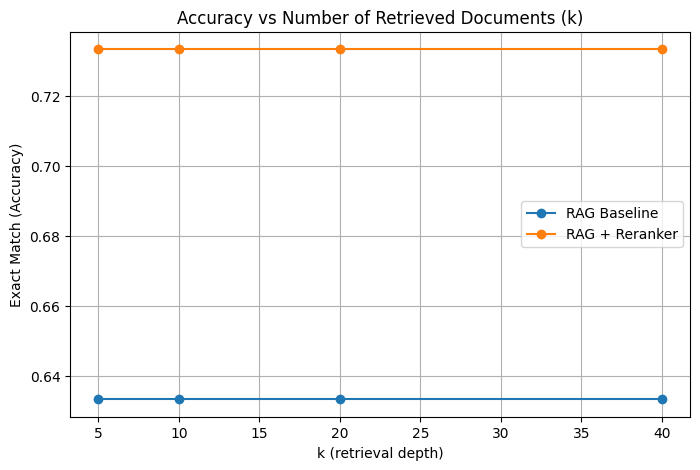

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(retrieval_ks, baseline_acc, marker='o', label="RAG Baseline")
plt.plot(retrieval_ks, rerank_acc, marker='o', label="RAG + Reranker")
plt.title("Accuracy vs Number of Retrieved Documents (k)")
plt.xlabel("k (retrieval depth)")
plt.ylabel("Exact Match (Accuracy)")
plt.grid(True)
plt.legend()
plt.show()


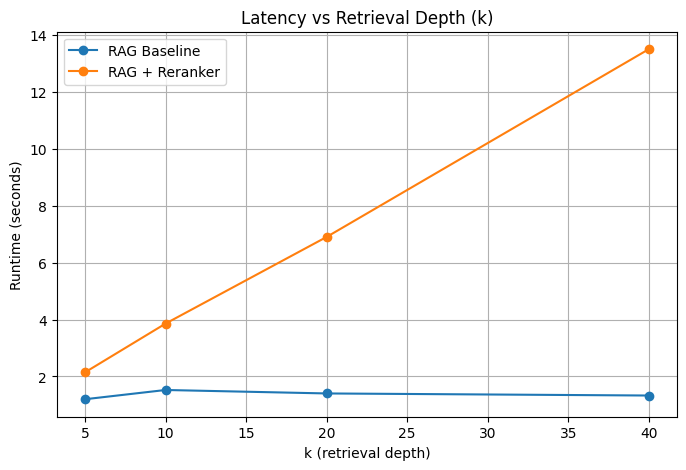

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(retrieval_ks, baseline_time, marker='o', label="RAG Baseline")
plt.plot(retrieval_ks, rerank_time, marker='o', label="RAG + Reranker")
plt.title("Latency vs Retrieval Depth (k)")
plt.xlabel("k (retrieval depth)")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def token_count(text, tokenizer=qa_pipeline.tokenizer):
    return len(tokenizer(text).input_ids)


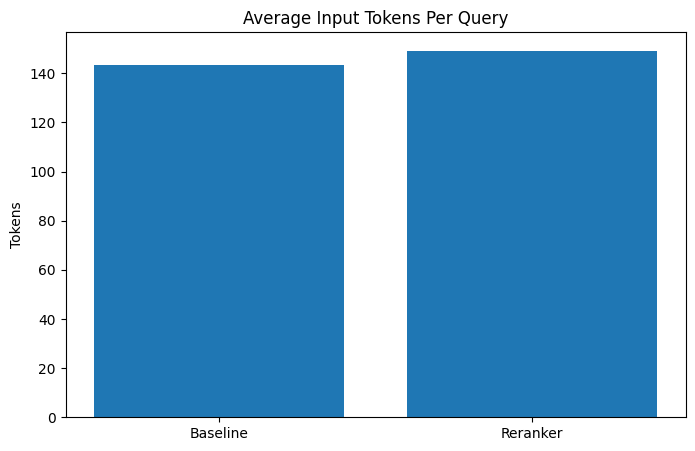

In [ ]:
baseline_tokens = []
rerank_tokens = []

for i in range(30):
    q = squad_val[i]["question"]
    
    # Baseline
    cand_idx, _ = retrieve_top_k(q, k=5)
    ctx = docs[cand_idx[0]]
    baseline_tokens.append(token_count(ctx))

    # Rerank
    cand_idx, _ = retrieve_top_k(q, k=20)
    reranked, _ = rerank_top_k(q, cand_idx, k=5)
    ctx = docs[reranked[0]]
    rerank_tokens.append(token_count(ctx))

plt.figure(figsize=(8,5))
plt.bar(["Baseline", "Reranker"], [np.mean(baseline_tokens), np.mean(rerank_tokens)])
plt.title("Average Input Tokens Per Query")
plt.ylabel("Tokens")
plt.show()
